In [1]:
# !wget -c https://moji.or.jp/wp-content/ipafont/IPAexfont/IPAexfont00401.zip
# !mkdir -p fonts
# !unzip -d fonts -o IPAexfont00401.zip
# !rm -f IPAexfont00401.zip

--2022-03-27 20:56:43--  https://moji.or.jp/wp-content/ipafont/IPAexfont/IPAexfont00401.zip
moji.or.jp (moji.or.jp) をDNSに問いあわせています... 157.7.44.215
moji.or.jp (moji.or.jp)|157.7.44.215|:443 に接続しています... 接続しました。
HTTP による接続要求を送信しました、応答を待っています... 200 OK
長さ: 9738669 (9.3M) [application/zip]
`IPAexfont00401.zip' に保存中

IPAexfont00401.zip  100%[===================>]   9.29M  2.39MB/s 時間 4.8s     

2022-03-27 20:56:48 (1.94 MB/s) - `IPAexfont00401.zip' へ保存完了 [9738669/9738669]

Archive:  IPAexfont00401.zip
   creating: fonts/IPAexfont00401/
  inflating: fonts/IPAexfont00401/ipaexg.ttf  
  inflating: fonts/IPAexfont00401/ipaexm.ttf  
  inflating: fonts/IPAexfont00401/IPA_Font_License_Agreement_v1.0.txt  
  inflating: fonts/IPAexfont00401/Readme_IPAexfont00401.txt  


In [9]:
import re
import sys
sys.path.append("/Users/ruinz/.pyenv/versions/3.9.5/lib/python3.9/site-packages")
import matplotlib.pyplot as plt
import spacy
import wordcloud
%matplotlib inline

input_fn = 'text/kageotoko.corpus.txt'

include_pos = ('NOUN', 'VERB', 'ADJ')
stopwords = ('する', 'ある', 'ない', 'いう', 'もの', 'こと', 'よう', 'なる', 'ほう', "なか", 'くる', "いる", 'とき')

nlp = spacy.load("ja_ginza")

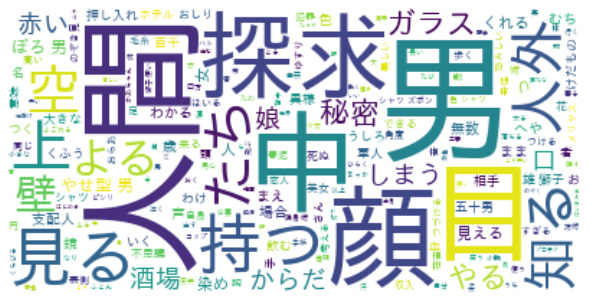

In [10]:
with open(input_fn, 'r') as f:
    text = f.read()

text = text[:15000]
doc = nlp(text)
words = [token.lemma_ for token in doc
         if token.pos_ in include_pos and token.lemma_ not in stopwords]

wc = wordcloud.WordCloud(
    background_color='white',
    font_path='fonts/IPAexfont00401/ipaexg.ttf',
    max_font_size=100)
img = wc.generate(' '.join(words))

plt.figure(figsize=(8, 4))
plt.imshow(img, interpolation='bilinear')
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

##　共起ネットワークの表示

In [11]:
import spacy 
input_fn = 'text/kageotoko.corpus.txt'

include_pos = ('NOUN', 'VERB', 'ADJ')
stopwords = ('する', 'ある', 'ない', 'いう', 'もの', 'こと', 'よう', 'なる', 'ほう', 'いる', 'くる')

nlp = spacy.load("ja_ginza")

In [12]:
def extract_words(sent, pos_tags, stopwords):
    words = [token.lemma_ for token in sent
             if token.pos_ in pos_tags and token.lemma_ not in stopwords]
    return words


In [13]:
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np

def count_cooccurrence(sents, token_length='{2,}'):
    token_pattern=f'\\b\\w{token_length}\\b'
    count_model = CountVectorizer(token_pattern=token_pattern)

    X = count_model.fit_transform(sents)
    words = count_model.get_feature_names_out()
    word_counts = np.asarray(X.sum(axis=0)).reshape(-1)

    X[X > 0] = 1 # limit to 1 occurrence in a document.
    Xc = (X.T * X) # this is co-occurrence matrix in sparse csr format
    return words, word_counts, Xc, X

In [15]:
with open(input_fn) as f:
    text = f.read()

text = text[:15000]

doc = nlp(text)
sents = [' '.join(extract_words(sent, include_pos, stopwords))
          for sent in doc.sents]
words, word_counts, Xc, X = count_cooccurrence(sents)

In [16]:
def word_weights(words, word_counts):
    count_max = word_counts.max()
    weights = [(word, {'weight': count / count_max})
               for word, count in zip(words, word_counts)]
    return weights

def cooccurrence_weights(words, Xc, weight_cutoff):
    Xc_max = Xc.max()
    cutoff = weight_cutoff * Xc_max
    weights = [(words[i], words[j], Xc[i,j] / Xc_max)
               for i, j in zip(*Xc.nonzero()) if i < j and Xc[i,j] > cutoff]
    return weights

In [17]:
import networkx as nx
from pyvis.network import Network
import matplotlib.pyplot as plt
import japanize_matplotlib

def create_network(words, word_counts, Xc, weight_cutoff):
    G = nx.Graph()
    
    weights_w = word_weights(words, word_counts)
    G.add_nodes_from(weights_w)
    
    weights_c = cooccurrence_weights(words, Xc, weight_cutoff)
    G.add_weighted_edges_from(weights_c)
    
    G.remove_nodes_from(list(nx.isolates(G)))
    return G

def pyplot_network(G):
    plt.figure(figsize=(10, 10))
    pos = nx.spring_layout(G, k=0.1)

    weights_n = np.array(list(nx.get_node_attributes(G, 'weight').values()))
    nx.draw_networkx_nodes(G, pos, node_size=300 * weights_n)
        
    weights_e = np.array(list(nx.get_edge_attributes(G, 'weight').values()))
    nx.draw_networkx_edges(G, pos, width=20 * weights_e)
    
    nx.draw_networkx_labels(G, pos, font_family='IPAexGothic')

    plt.axis("off")
    plt.show()

def nx2pyvis_G(G):
    pyvis_G = Network(width='800px', height='800px', notebook=True)
    # pyvis_G.from_nx(G) # pyvisライブラリ現状では，属性が反映されない．
    for node, attrs in G.nodes(data=True):
        pyvis_G.add_node(node, title=node, size=30 * attrs['weight'])
    for node1, node2, attrs in G.edges(data=True):
        pyvis_G.add_edge(node1, node2, width=20 * attrs['weight'])
    return pyvis_G

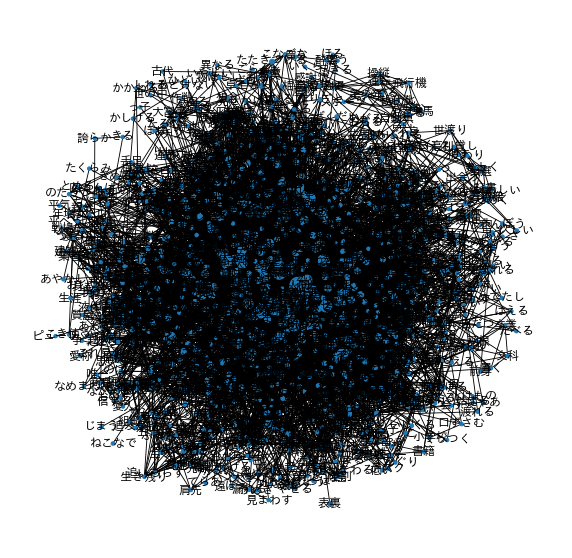

In [18]:
G = create_network(words, word_counts, Xc, 0.03)
pyplot_network(G)
pyvis_G = nx2pyvis_G(G)
pyvis_G.show("mygraph.html")

In [19]:
def find_sentence_by_cooccurrence(X, idxs):
    occur_flags = (X[:,idxs[0]] > 0)
    for idx in idxs[1:]:
        occur_flags = occur_flags.multiply(X[:,idx] > 0)
    return occur_flags.nonzero()[0]

sents_orig = list(doc.sents)
words_lookup = {word: index for index, word in enumerate(words)}
idxs = [words_lookup[word] for word in ['人間', '探求']]

for i in find_sentence_by_cooccurrence(X, idxs):
    print("{:>5d}: {}".format(i, sents_orig[i]))

  153: かれは人間というものの探求を生きがいとするようになっていた。
  156: かれはその裏側のほうの人間を探求しようとしたのである。
  158: しかし、普通犯罪学者がやるような一般的研究ではなくて、これと目ざした個々の人間の、世間にも、その人自身の家族にさえも知られていない秘密の生活を探求することが、かれの生きがいであった。
  208: 
　かれの人間裏返しの探求には、いま一つの副産物があった。
  214: かれの「裏返しの人間探求」の副産物にすぎなかった。
  217: 隠身術による人間探求の結果を、小説の形でそれとなく世間に見せびらかすのが楽しかったのである。
  230: それらの恋人を、かれは人間探求事業の助手として巧みに駆使していた。
